[########################################] | 100% Completed | 1.70 ss


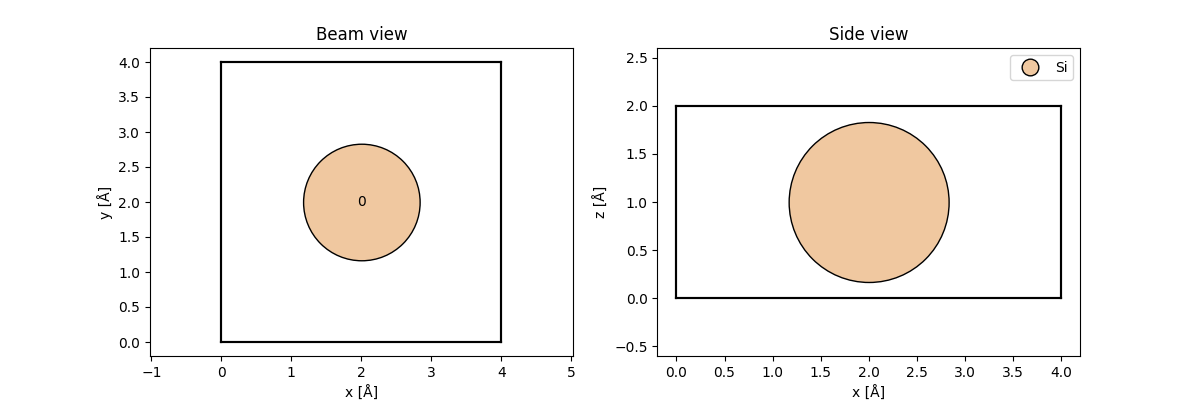

In [1]:
import ase
import numpy as np
import abtem
import matplotlib.pyplot as plt
from typing import Tuple, NamedTuple

%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib ipympl

# atoms = ase.Atoms(
#     "Si2", positions=[(1.0, 2.0, 1.0), (3.0, 2.0, 1.0)], cell=[4, 4, 2]
# )

atoms = ase.Atoms(
    "Si1", positions=[(2.0, 2.0, 1.0),], cell=[4, 4, 2]
)


phi_0 = 100e3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.4, projection="infinite")

potential_array = potential.build().project().compute()
pot_array = np.flip(potential_array.array, axis=0)


In [2]:
class PlotParams(NamedTuple):
    num_rays: int = 10
    ray_color: str = 'dimgray'
    fill_color: str = 'aquamarine'
    fill_color_pair: Tuple[str, str] = ('khaki', 'deepskyblue')
    fill_alpha: float = 0.0
    ray_alpha: float = 1.
    component_lw: float = 1.
    edge_lw: float = 1.
    ray_lw: float = 1.
    label_fontsize: int = 12
    figsize: Tuple[int, int] = (6, 6)
    extent_scale: float = 1.1


[                                        ] | 0% Completed | 1.23 ms

[########################################] | 100% Completed | 113.64 ms


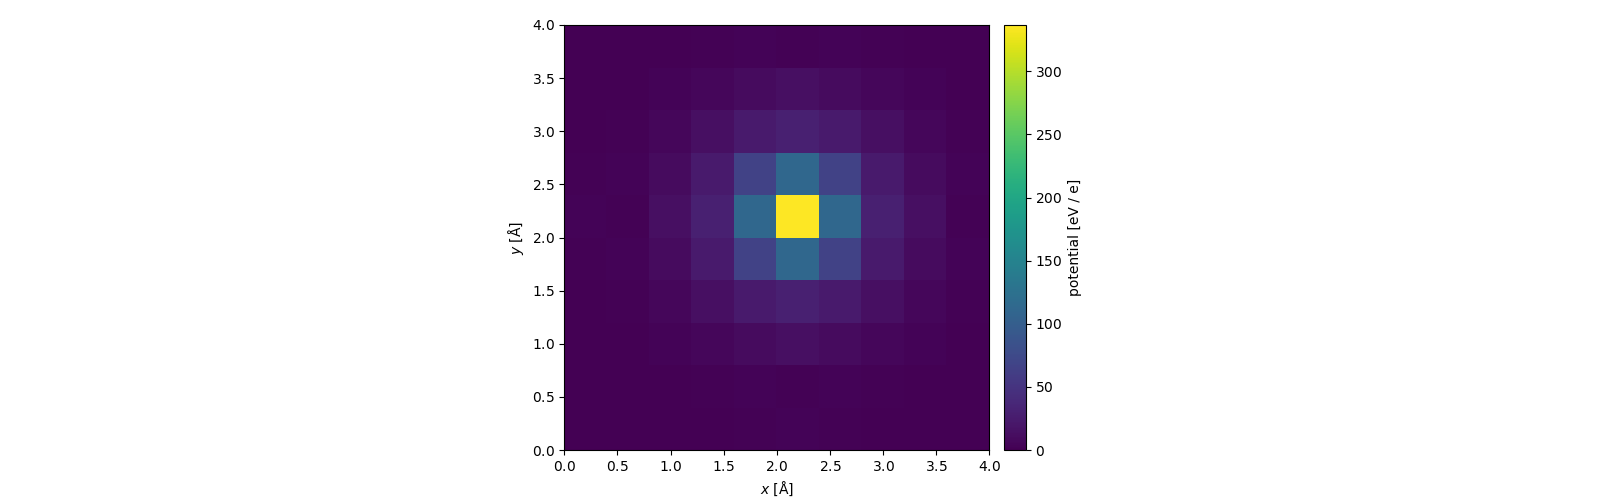

In [3]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

[########################################] | 100% Completed | 321.55 ms


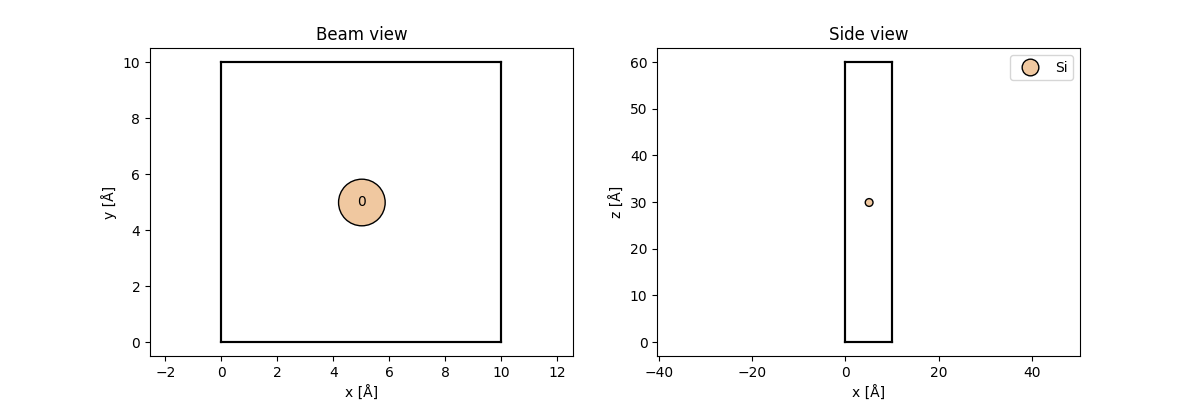

In [4]:
x1 = 1.0
atom_spacing = 3.0
x2 = x1 + atom_spacing
x_centre = 5.0
x0 = x_centre - (x1) - atom_spacing/2
z = 30
# atoms = ase.Atoms(
#     "Si2", positions=[(x0+x1, x_centre, z), (x0+x2, x_centre, z)], cell=[x_centre*2, x_centre*2, 60]
# )

atoms = ase.Atoms(
    "Si1", positions=[(x_centre, x_centre, z)], cell=[x_centre*2, x_centre*2, 60]
)

phi_0 = 100e3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.1, projection="infinite")

potential_array = potential.build().project().compute()


[########################################] | 100% Completed | 229.33 ms


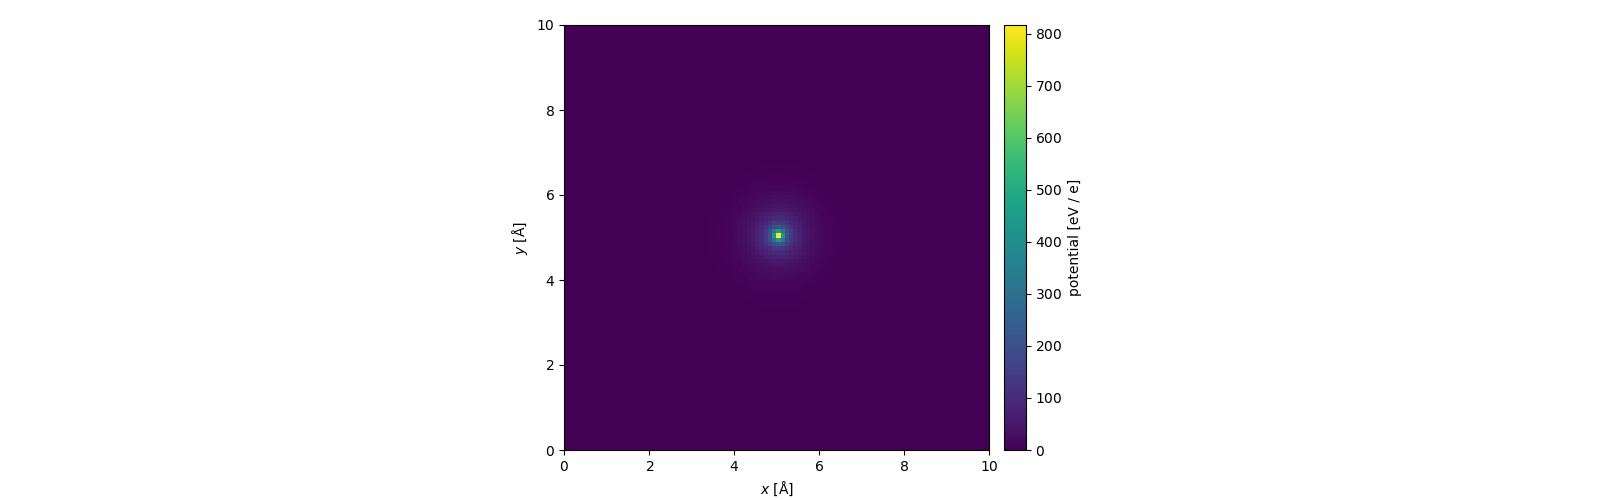

In [5]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

(100, 100)


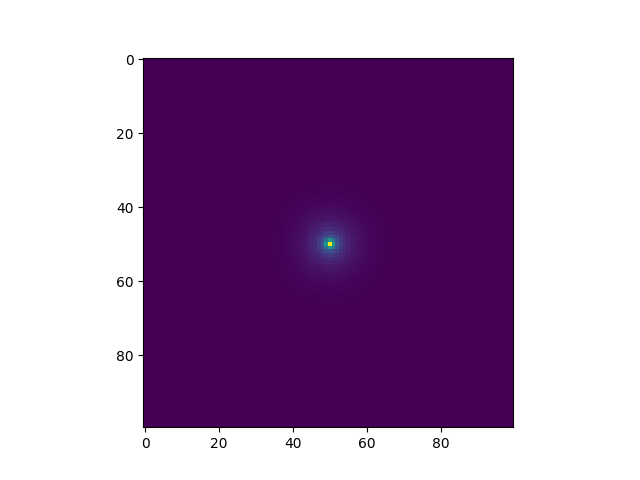

In [6]:
plt.figure()
plt.imshow(potential_array.array.T)

print(potential_array.shape)

In [7]:
phi_0 = 100e3
plane_wave = abtem.PlaneWave(energy=100e3)
exit_wave = plane_wave.multislice(potential)
exit_wave.compute()

[########################################] | 100% Completed | 491.68 ms


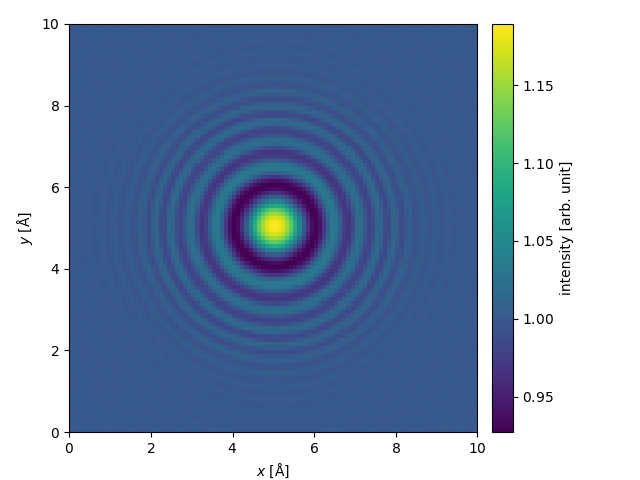

In [8]:
exit_wave.intensity().show(cbar=True)
intensity = exit_wave.intensity().compute()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from diffractio import um, nm, mm, np
from diffractio.scalar_fields_X import Scalar_field_X
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X

from numba import njit
%matplotlib ipympl

(0.0, -6e-09)

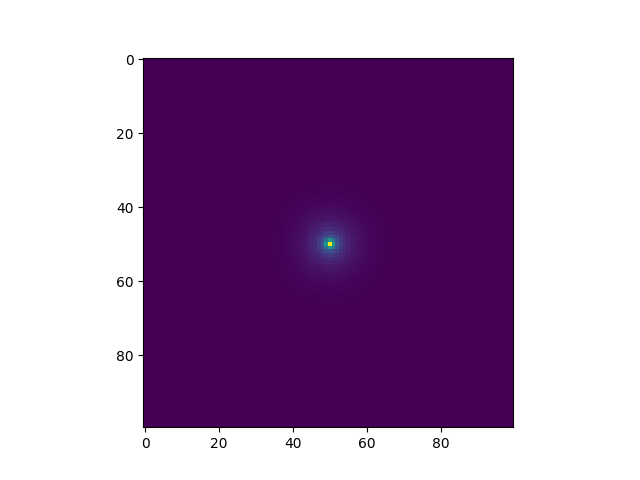

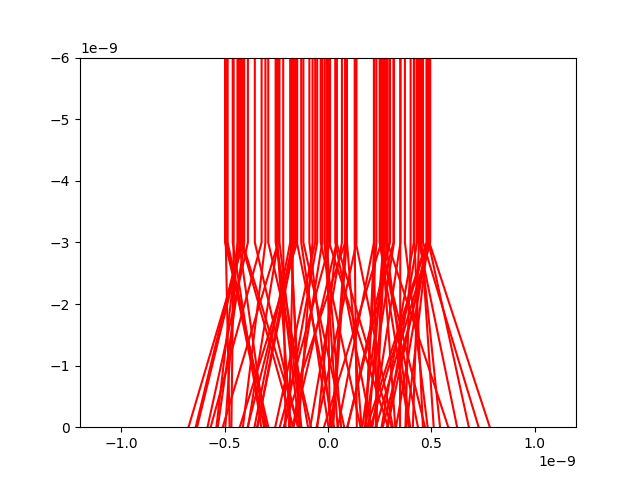

In [9]:
from scipy.interpolate import RegularGridInterpolator as RGI

from temgymbasic.model import (
    Model,
)
import temgymbasic.components as comp
from temgymbasic.rays import Rays

num_rays = 100

x0 = -5 * 1e-10
y0 = -5 * 1e-10

extent = np.array(potential.extent) * 1e-10
gpts = potential.gpts
x = np.linspace(x0, x0 + extent[0], gpts[0], endpoint=True)
y = np.linspace(y0, y0 + extent[1], gpts[1], endpoint=True)
xx, yy = np.meshgrid(x, y, indexing='ij')

phi_r = potential_array.array.T  # Be very careful with this - transpose only works because we have symmetry!

plt.figure()
plt.imshow(phi_r)

pot_interp = RGI([x, y], phi_r, method='linear', bounds_error=False, fill_value=0.0)
samples = (1, 100)*1e-11
detector_pixels = 100
components = (
    comp.XAxialBeam(
        z=-60e-10,
        radius=5e-10,
        voltage=phi_0
    ),
    comp.MultisliceSample(
        z=-30e-10,
        potential=pot_interp,
        samples=samples
    ),
    comp.Detector(
        z=0,
        pixel_size=1e-11,
        shape=(1, 100),
    ),
)


model = Model(components)
rays = tuple(model.run_iter(num_rays=num_rays))
x = np.stack(tuple(r.x for r in rays), axis=0)
y = np.stack(tuple(r.y for r in rays), axis=0)
z = np.asarray(tuple(r.z for r in rays))

fig, ax = plt.subplots()
ax.plot(x, z, '-r')

max_x = 12e-10
min_x = -12e-10
min_z = np.min([np.min(z)] + [c.z for c in model.components])
max_z = np.max([np.max(z)] + [c.z for c in model.components])

ax.set_xlim([-max_x, max_x])
ax.set_ylim([max_z, min_z])

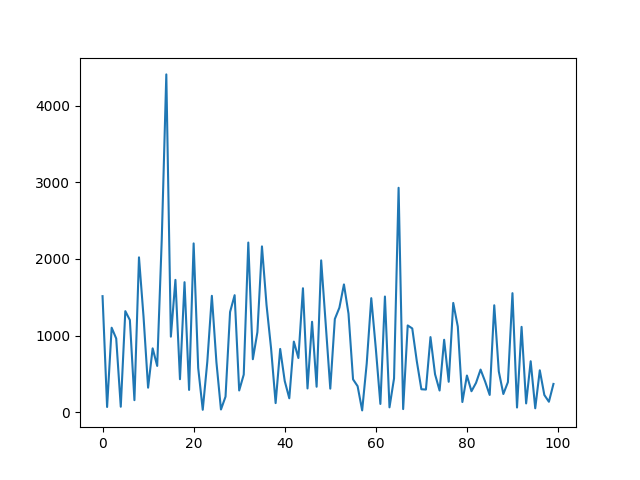

In [11]:
num_iter = 100
num_rays = 1000
monte_carlo_image = np.zeros((1, 100), dtype=np.complex128)

for i in range(num_iter):
    rays = model.run_to_end(num_rays=num_rays)
    monte_carlo_image += model.detector.get_image(rays, interference=True)

plt.figure()
plt.plot(np.abs(monte_carlo_image[0, :])**2)

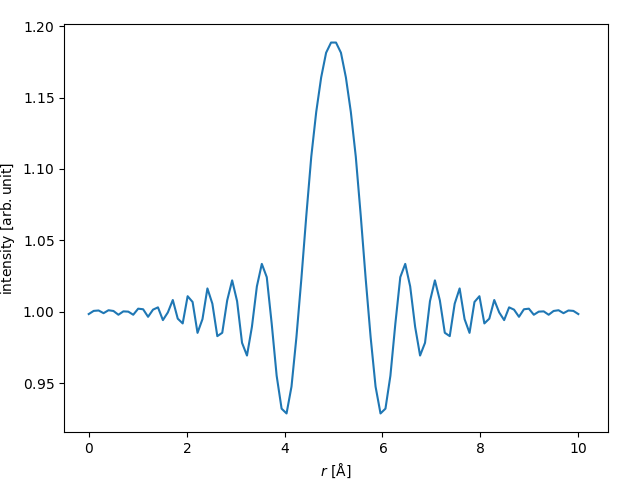

In [19]:
lineprofile = intensity.interpolate_line_at_position(
    center=(5, 5), angle=0, extent=10
)
lineprofile.show()

In [12]:
potential_series = abtem.Potential(
    atoms, slice_thickness=0.05, sampling=0.04, exit_planes=2
)

exit_wave_series = plane_wave.multislice(potential_series).compute()

[                                        ] | 0% Completed | 902.40 us

[########################################] | 100% Completed | 11.87 s


(601, 250, 250)


IndexError: index 250 is out of bounds for axis 2 with size 250

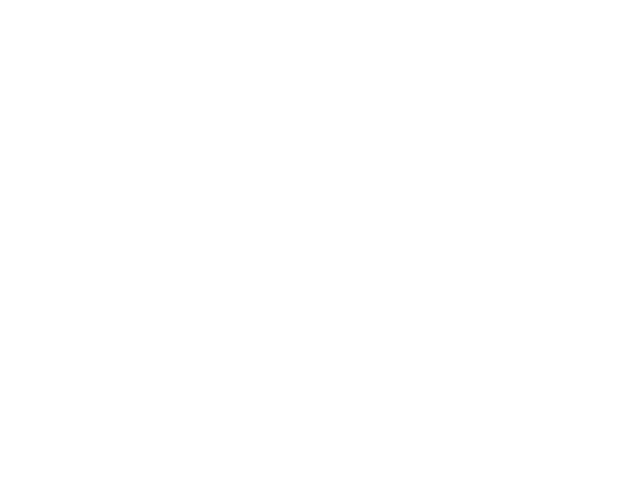

In [13]:
print(exit_wave_series.shape)

plt.figure()
plt.imshow(np.abs(exit_wave_series.array[:, :, 250]**2), extent=[0, 20, 0, 60], cmap='viridis', aspect='auto')
plt.xlabel('x [Å]')
plt.ylabel('z [Å]')
plt.plot(x*1e10 + 10, -1*z*1e10, '-r')
plt.xlim([0, 20.0])


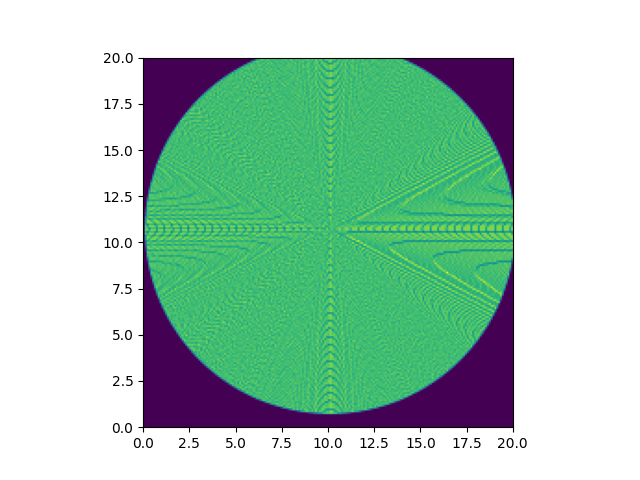

In [ ]:
model = Model(components)
rays = tuple(model.run_iter(num_rays=2**20))
wavefront = model.detector.get_image(rays[-1])

plt.figure()
plt.imshow(np.abs(wavefront)**2, extent=[0, 20, 0, 20])